In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv("clusterized_df.csv", encoding = "ISO-8859-1")
df.head()

,article,cluster,topic
0,"['musician', 'tackle', 'u', 'red', 'tape', 'mu...",4,business
1,"['u2s', 'desire', 'number', 'one', 'u2', 'thre...",0,entertainment
2,"['rocker', 'doherty', 'onstage', 'fight', 'roc...",0,entertainment
3,"['snicket', 'top', 'u', 'box', 'office', 'char...",0,entertainment
4,"['ocean', 'twelve', 'raid', 'box', 'office', '...",0,entertainment


In [31]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# load the training and test data into dataframes
# extract the feature and target columns

X = df["article"]
y = df["cluster"]

# split the dataframe into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

import pickle
with open("count_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

k_range = list(range(1, 21, 2))
param_grid_knn = {'n_neighbors': k_range, 'algorithm': ['brute'], 'weights': ['uniform', 'distance'],
              'metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']}

param_grid_dt = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

param_grid_rf = {'n_estimators' : [5, 10, 20, 30, 50, 100, 150, 200],
                'max_depth': [None, 10, 15, 20, 25, 50, 100],
                'max_samples': [None, 0.2, 0.35, 0.5, 0.8],
                'max_leaf_nodes': [None, 5, 10, 20, 30, 50, 100]}

# initialize the classifiers
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

knn.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# tune the parameters with GridSearchCV
#grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
#grid_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5)
#grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=5)

knn_best_params = {'algorithm': 'brute', 'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}
dt_best_params = {'max_depth': 10}
rf_best_params = {'max_depth': None, 'max_leaf_nodes': None, 'max_samples': None, 'n_estimators': 150}

grid_knn = KNeighborsClassifier(**knn_best_params)
grid_dt = DecisionTreeClassifier(**dt_best_params)
grid_rf = RandomForestClassifier(**rf_best_params)

# train the classifiers on the training data
grid_knn.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

with open('DT_model.pickle', 'wb') as f:
    pickle.dump(grid_dt, f)

with open('RF_model.pickle', 'wb') as f:
    pickle.dump(grid_rf, f)

# make predictions on the test data
y_pred_knn = grid_knn.predict(X_test)
y_pred_dt = grid_dt.predict(X_test)
y_pred_rf = grid_rf.predict(X_test)


# evaluate the classifiers' performance
print("KNN:")
print(classification_report(y_test, y_pred_knn))
print("Decision Tree:")
print(classification_report(y_test, y_pred_dt))
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

KNN:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        72
           1       0.81      0.96      0.88        56
           2       0.95      0.93      0.94       106
           3       0.91      0.93      0.92        75
           4       0.89      0.85      0.87       136

    accuracy                           0.91       445
   macro avg       0.91      0.92      0.91       445
weighted avg       0.91      0.91      0.91       445

Decision Tree:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        72
           1       0.80      0.79      0.79        56
           2       0.92      0.85      0.88       106
           3       0.80      0.64      0.71        75
           4       0.73      0.91      0.81       136

    accuracy                           0.82       445
   macro avg       0.83      0.80      0.81       445
weighted avg       0.82      0.82      0.81       445

Ra

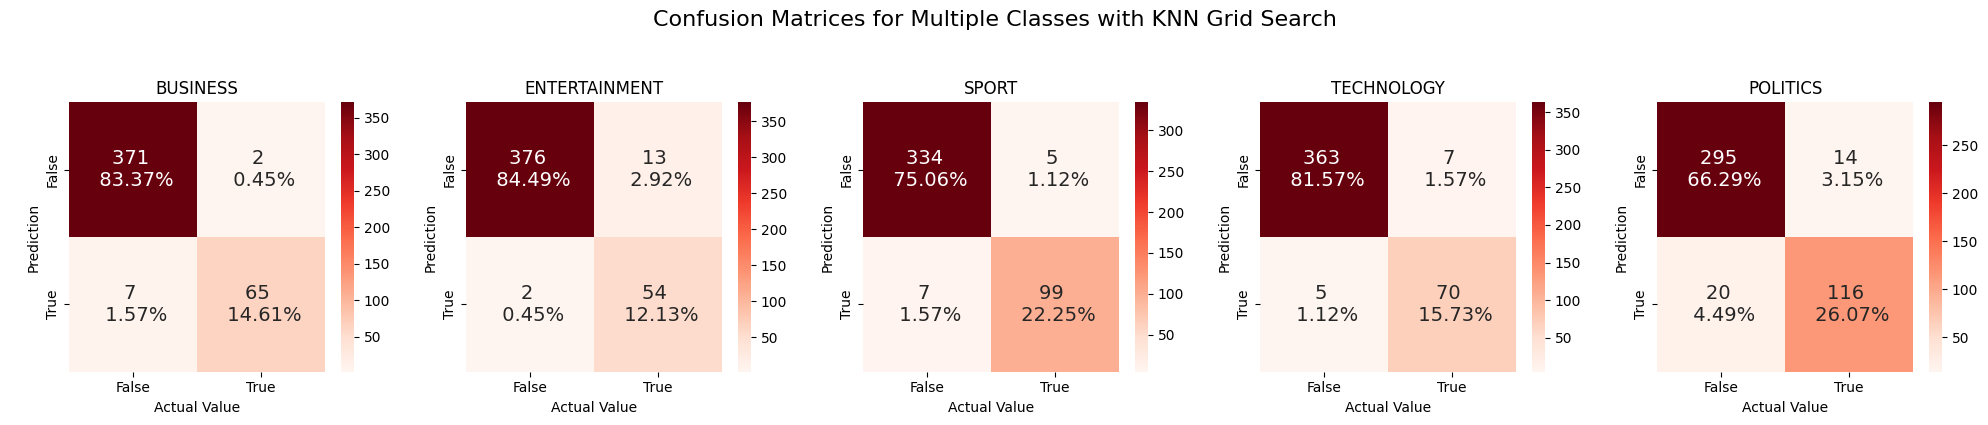

KNN
average accuracy without optimization: 96.40%
average accuracy with Grid Search: 96.31%


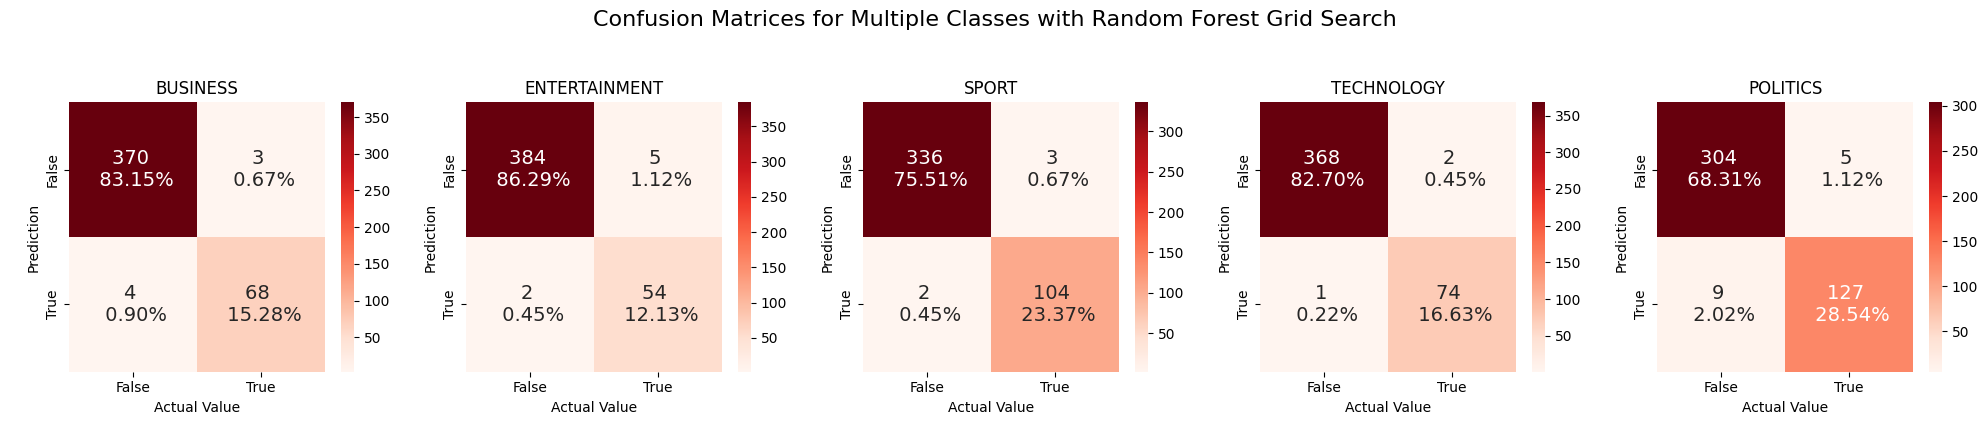

RANDOM FOREST
average accuracy without optimization: 98.11%
average accuracy with Grid Search: 98.38%


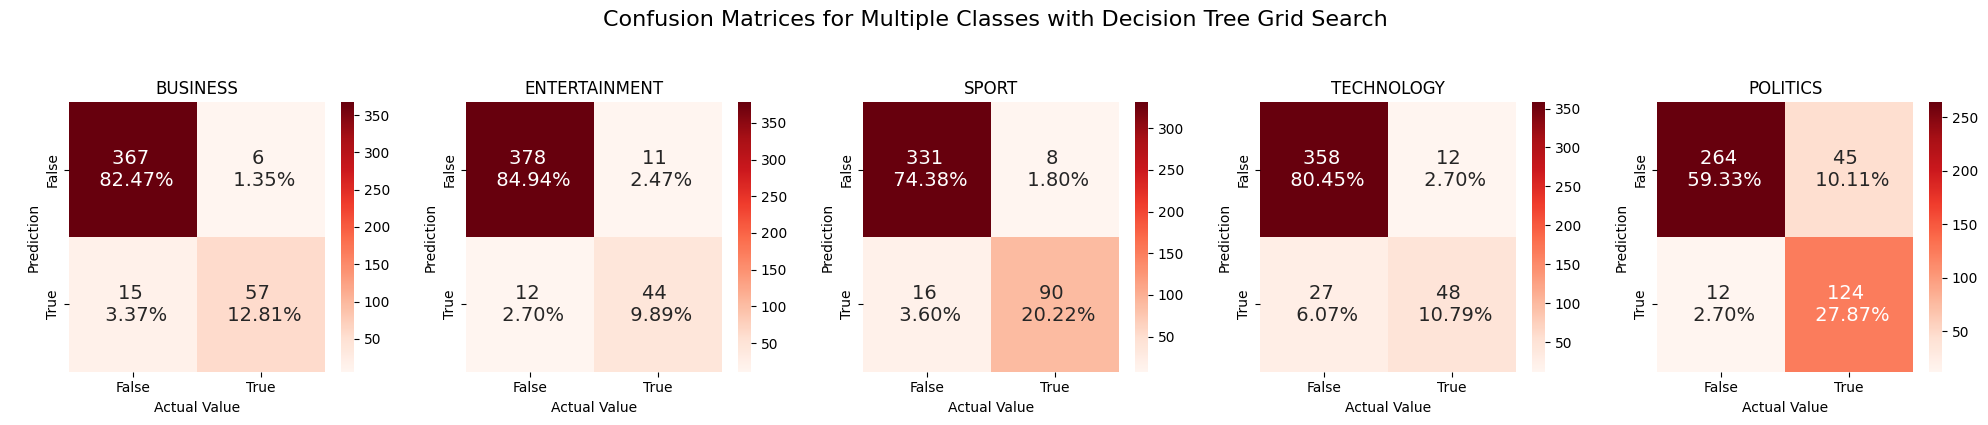

DECISION TREE
average accuracy without optimization: 94.52%
average accuracy with Grid Search: 92.63%


In [32]:
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

algorithms = [("KNN", y_pred_knn, knn),
              ("Random Forest", y_pred_rf, random_forest),
              ("Decision Tree", y_pred_dt, decision_tree)]

labels = df["topic"].unique().tolist()

for algo, y_pred, model in algorithms:
    cf_matrix_grid = multilabel_confusion_matrix(y_test, y_pred)
    accuracy_grid = []
    fig, axs = plt.subplots(1, len(labels), figsize=(20, 4), tight_layout=True)

    for i, ax in enumerate(axs):
        m = cf_matrix_grid[i]
        accuracy_grid.append((m[0][0]+m[1][1])/np.sum(m))
        group_counts = ["{0:0.0f}".format(value) for value in m.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in m.flatten()/np.sum(m)]
        values = [f"{v1} \n {v2}" for v1, v2 in zip(group_counts,group_percentages)]
        values = np.asarray(values).reshape(2,2)

        sns.heatmap(m, annot=values, cmap='Reds', fmt="", ax=ax, annot_kws = {"fontsize":14})
        ax.set_title(f"{labels[i].upper()}")
        ax.set_ylabel('\nPrediction')
        ax.set_xlabel('Actual Value')
        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])

    fig.suptitle(f"Confusion Matrices for Multiple Classes with {algo} Grid Search", fontsize=16, y=1.05)
    plt.show()

    cf_matrix = multilabel_confusion_matrix(y_test, model.predict(X_test))
    accuracy_ = [((m[0][0]+m[1][1])/np.sum(m)) for m in cf_matrix]

    moy_accuracy = statistics.mean(accuracy_)
    moy_accuracy_grid = statistics.mean(accuracy_grid)
    print(f"{algo.upper()}")
    print(f"average accuracy without optimization: {moy_accuracy*100:.2f}%")
    print(f"average accuracy with Grid Search: {moy_accuracy_grid*100:.2f}%")


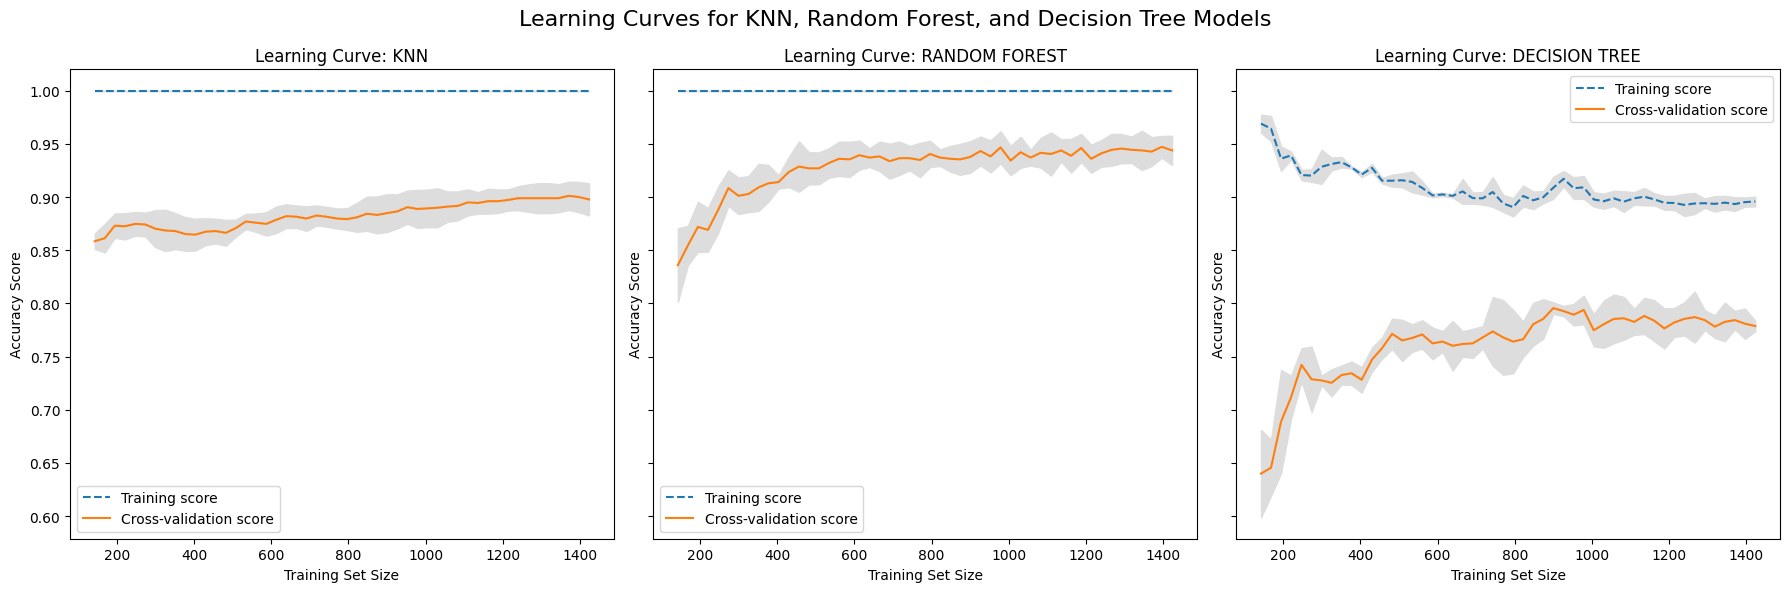

In [33]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6), sharey=True)
algo_models = [grid_knn, grid_rf, grid_dt]
algo_names = ["KNN", "Random Forest", "Decision Tree"]

for i, (algo, model) in enumerate(zip(algo_names, algo_models)):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 50))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    ax[i].plot(train_sizes, train_mean, '--',  label="Training score")
    ax[i].plot(train_sizes, test_mean, label="Cross-validation score")

    ax[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    ax[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    ax[i].set_title(f"Learning Curve: {algo.upper()}")
    ax[i].set_xlabel("Training Set Size"), ax[i].set_ylabel("Accuracy Score"), ax[i].legend(loc="best")

fig.suptitle("Learning Curves for KNN, Random Forest, and Decision Tree Models", fontsize=16)
fig.tight_layout()
plt.show()